In [74]:
%load_ext autoreload
%autoreload 2
import param_tool as pt
import os 
import numpy as np
from rdkit.Chem.Draw import IPythonConsole
import sys
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdFMCS
from typing import Callable
import psiresp
import nglview as nv
import MDAnalysis as mda
import glob
import pandas as pd

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, clear_output

IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = (600, 400)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
def mol2_to_chem(path_to_mol2, sanitize=True, removeHs=False):
    rdkit_chem = Chem.MolFromMol2File(path_to_mol2, sanitize=sanitize, removeHs=removeHs)
    if rdkit_chem:
        AllChem.Compute2DCoords(rdkit_chem)
    return rdkit_chem

In [76]:
def draw_mol_with_atom_index(mol, charge_list=None, size=(600, 400)):
    """
    Добавляет номера атомов в атрибуты атомов молекулы и рисует молекулу.
    """
    if charge_list is not None and len(charge_list) == len(mol.GetAtoms()):
        for i, atom in enumerate(mol.GetAtoms()):
            atom.SetAtomMapNum(atom.GetIdx())
            atom.SetDoubleProp('PartialCharge', float(charge_list[i]))  # Преобразование в float
            atom.SetProp('atomNote', str(f"{charge_list[i]:.4f}"))
    else:
        for i, atom in enumerate(mol.GetAtoms()):
            atom.SetAtomMapNum(atom.GetIdx())

    return Draw.MolToImage(mol, size)

,Molecule_Name,2D_Image,Has_Charged_Atoms,Total_Charge,Num_Atoms,Atom_Types
2,4abg,,True,2,36,"C,H,N"
4,4j28,,True,1,33,"C,H,N,O"
5,2cet,,True,1,43,"C,H,N,O"
10,1syi,,True,0,30,"C,H,N,O"
11,1owh,,True,2,44,"C,H,N,O"
12,4pcs,,True,1,32,"C,H,N,O"
14,3ag9,,True,3,140,"C,H,N,O"
21,3f3a,,True,0,27,"C,H,N,O"
22,2xys,,True,1,48,"C,H,N,O"
24,4e6q,,True,1,47,"C,H,N"

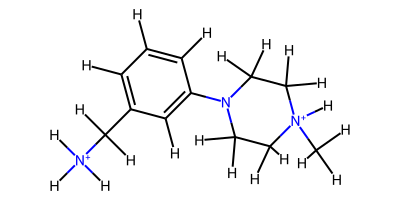
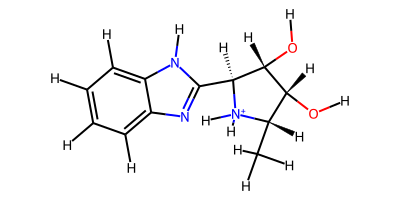
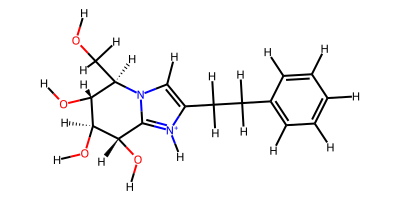
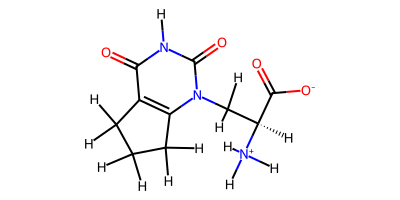
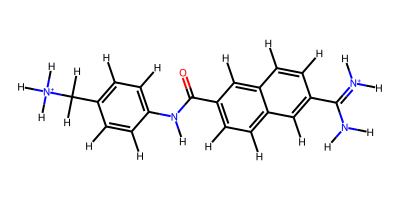
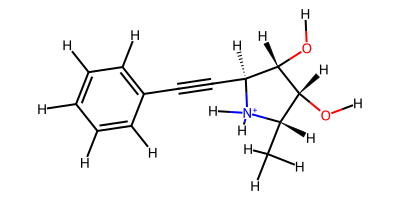
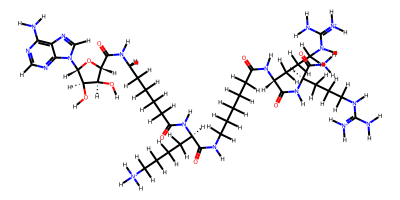
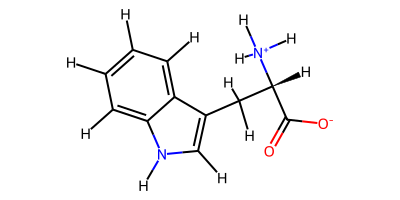
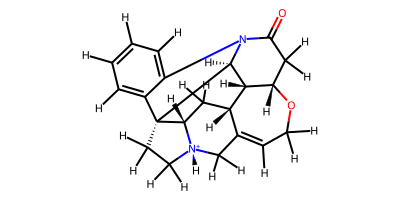
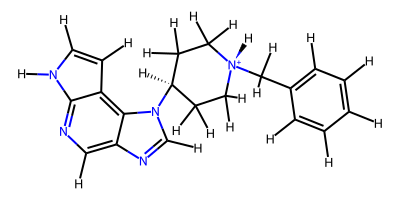
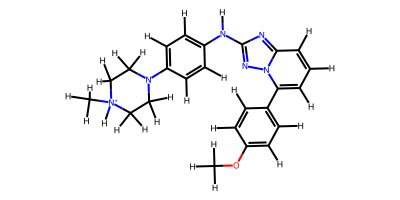
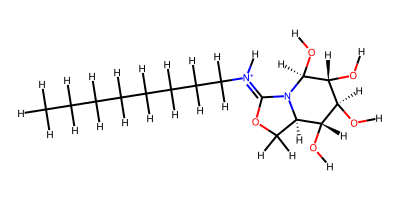
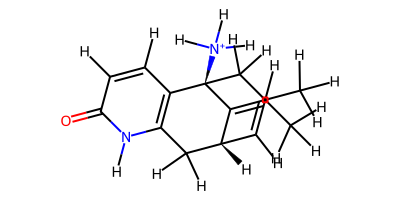
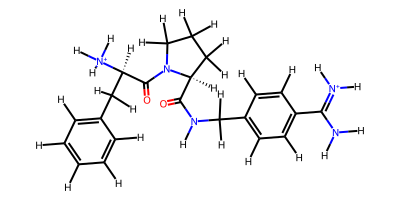
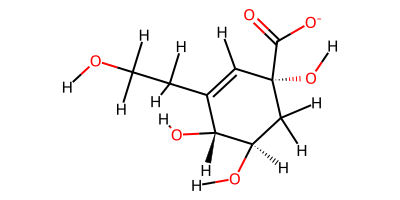
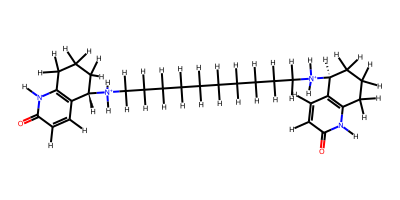
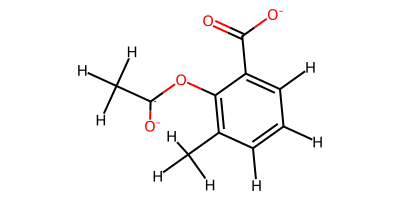
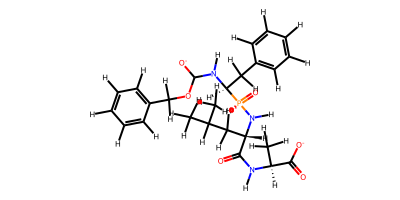
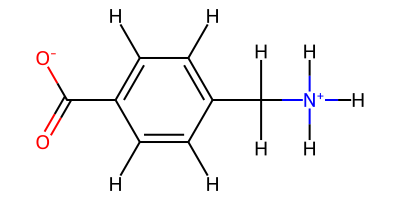
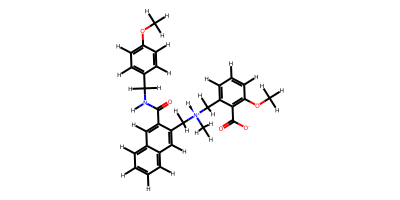
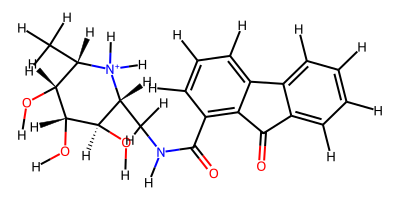
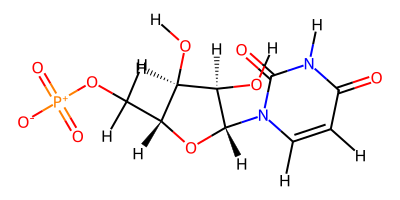
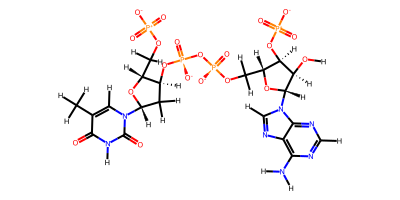
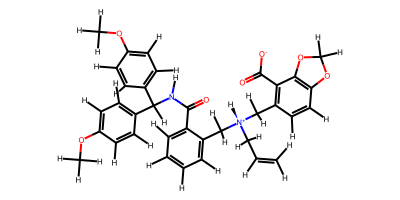
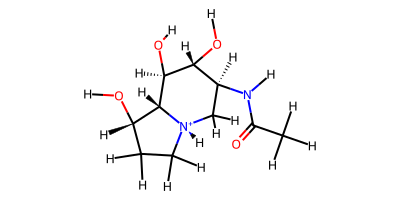
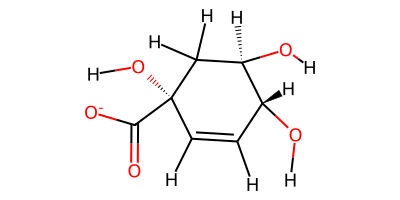
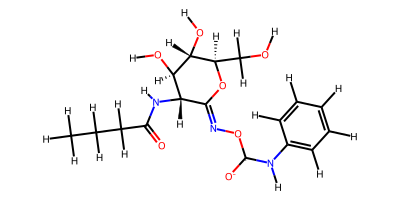
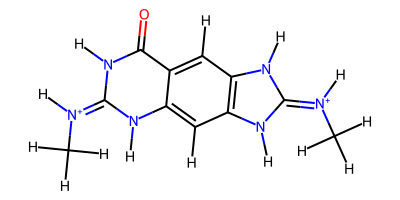
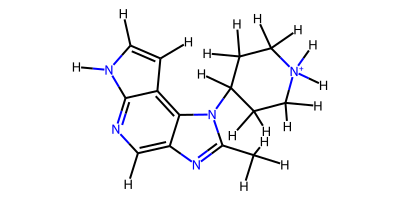
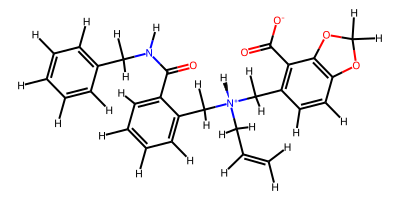
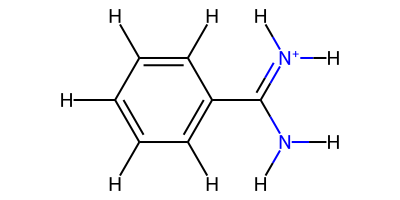
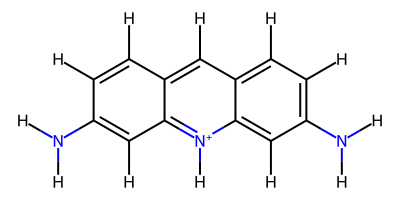
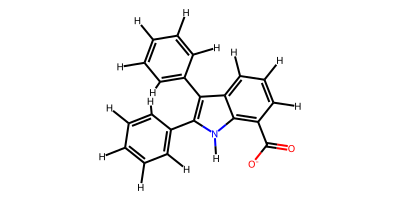
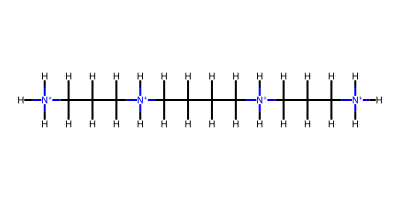
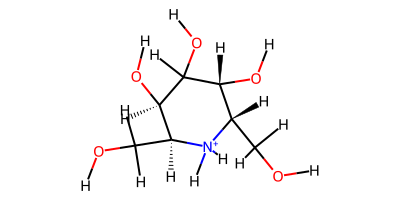
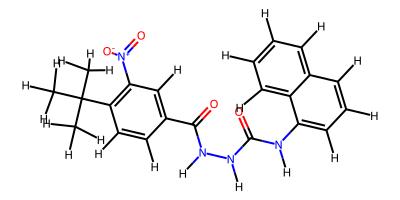
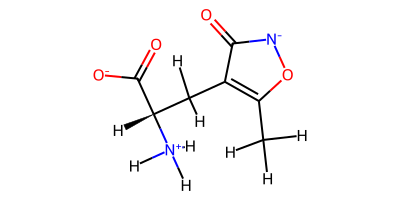
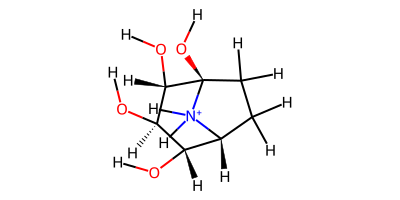
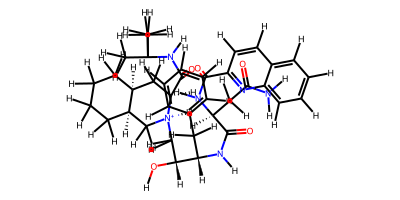
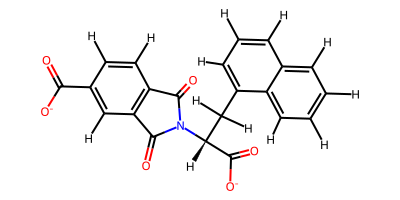
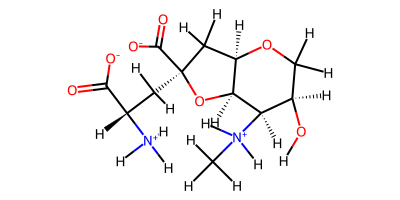
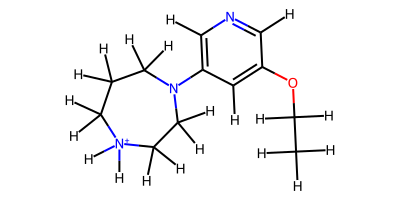
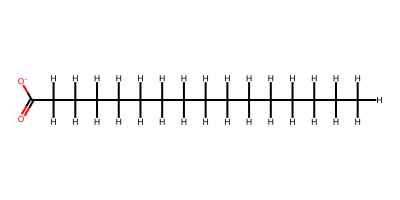
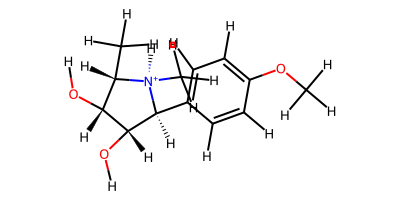
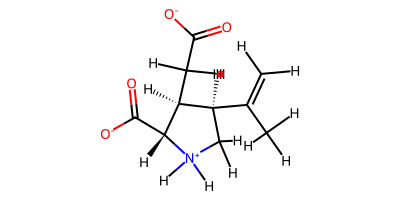
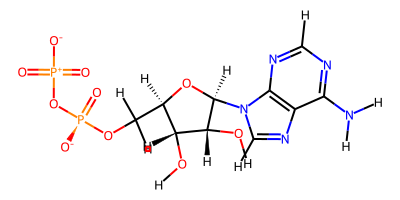
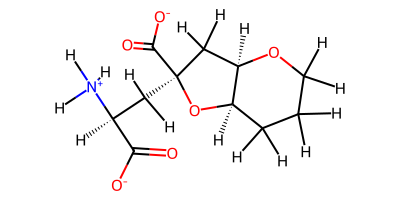
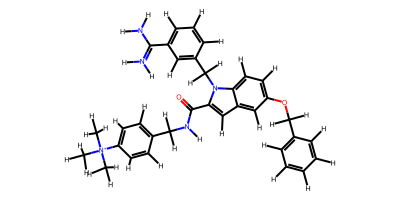
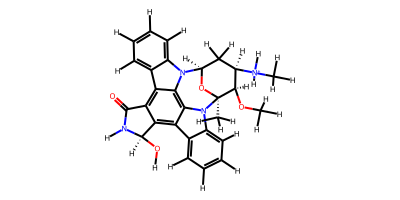
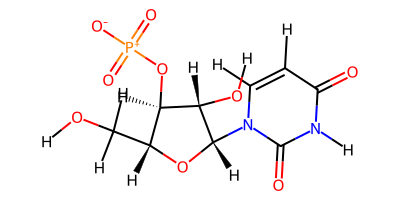
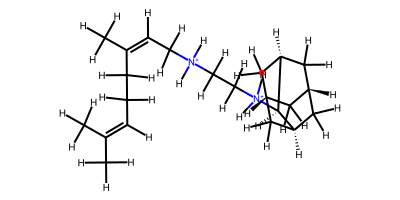
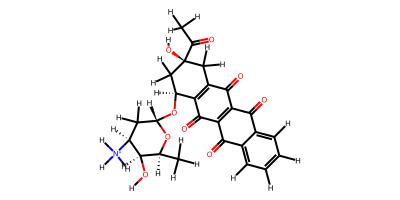
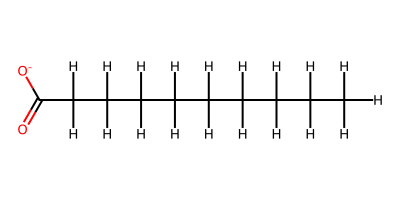
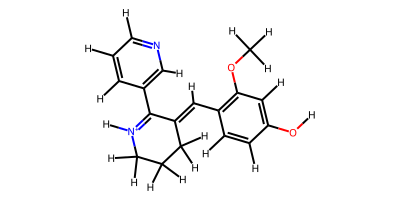
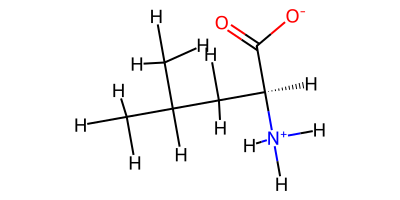
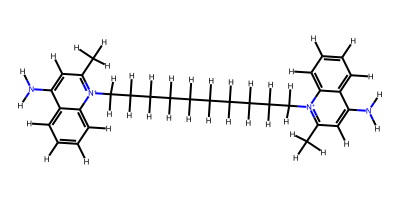
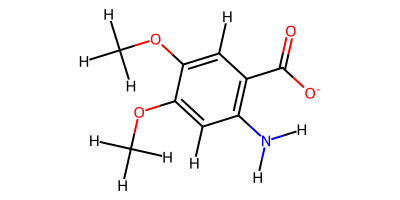
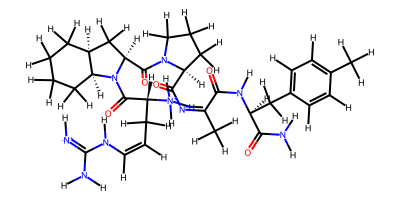
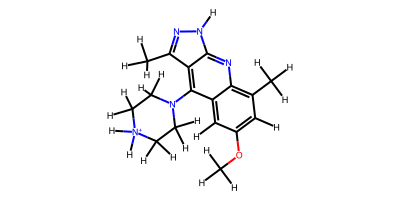
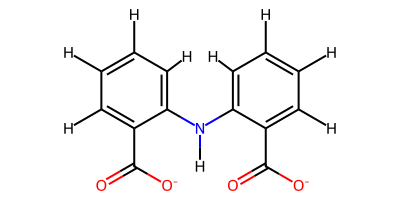
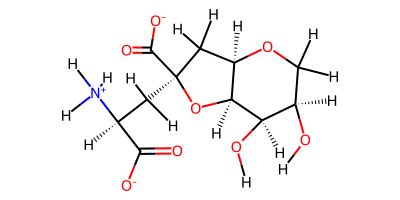
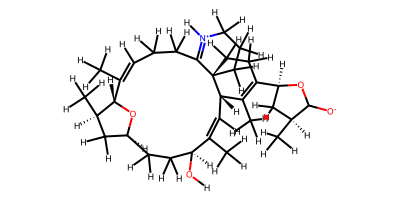
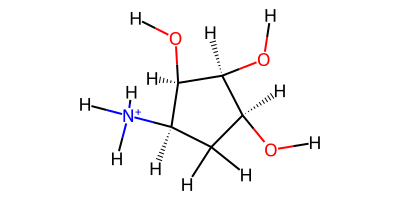
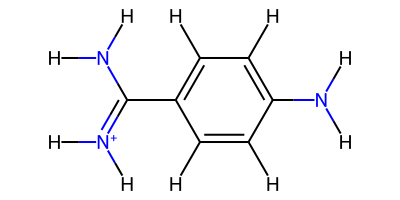
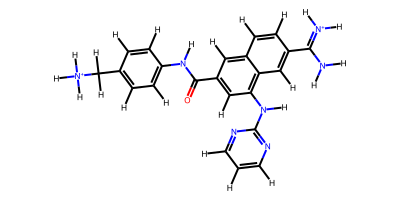
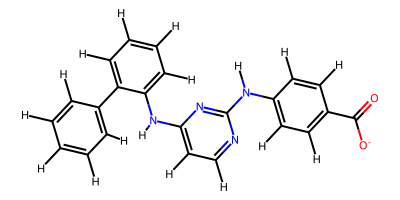
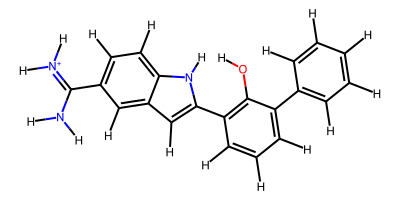
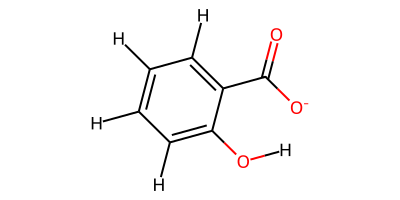
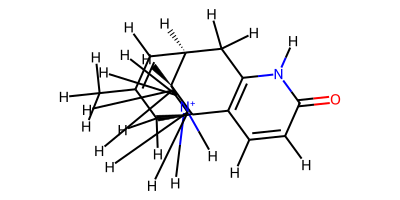
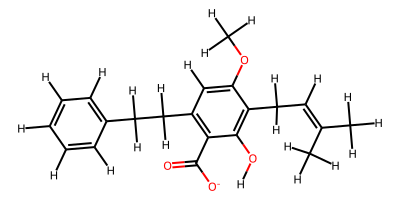
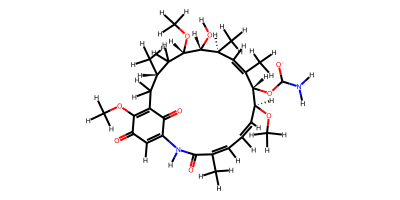
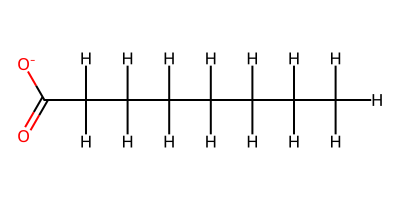
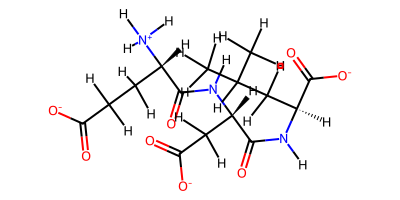
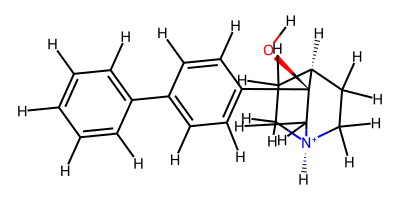
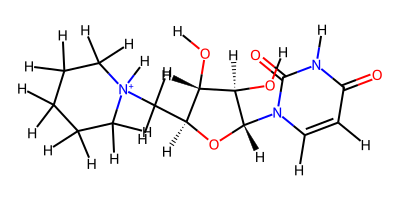
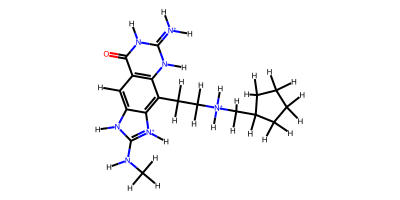
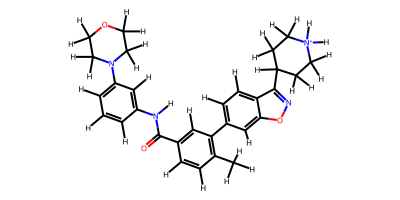
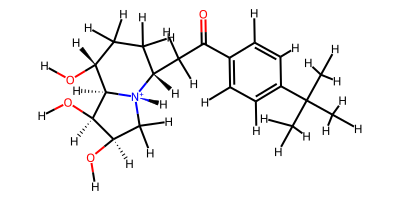
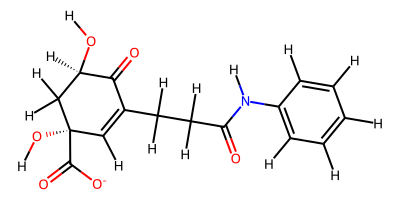
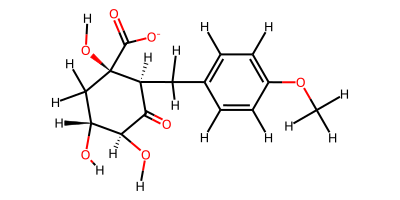
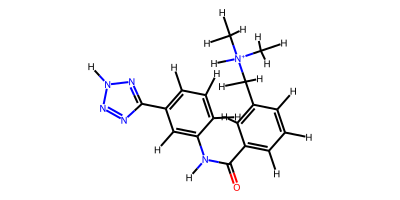
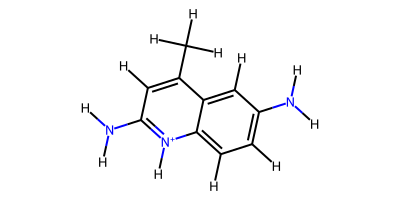
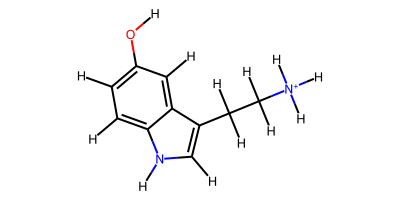
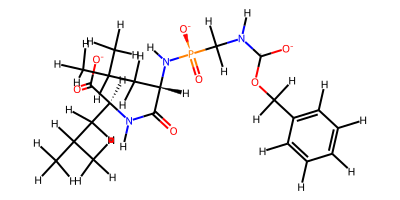
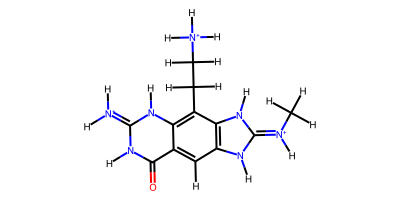
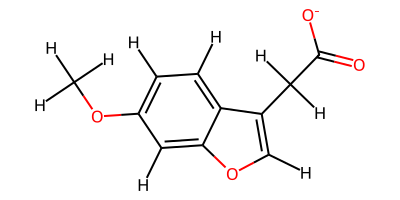
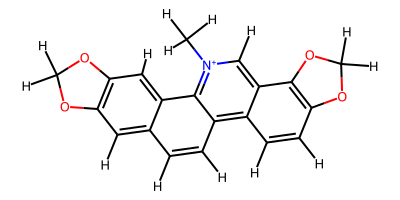
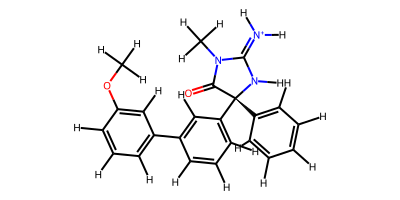
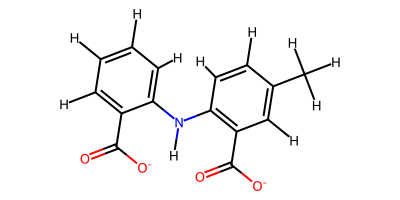
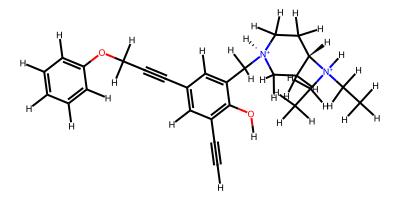
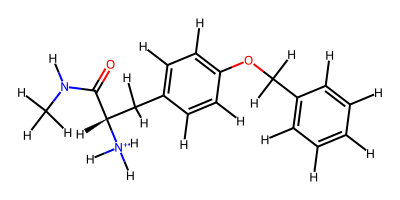
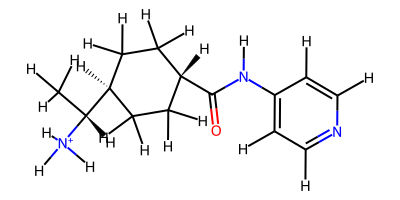
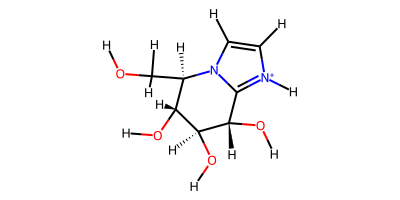
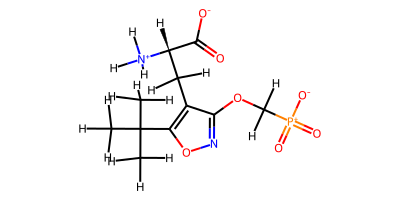
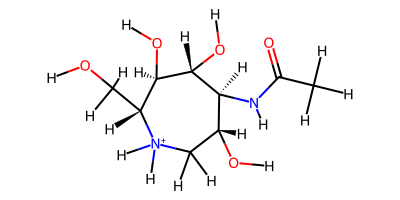
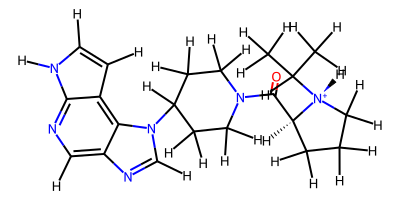
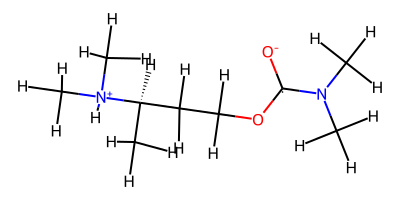
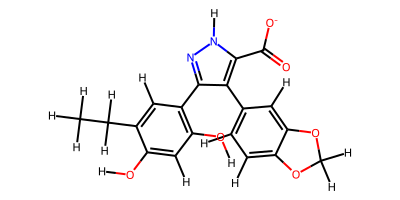
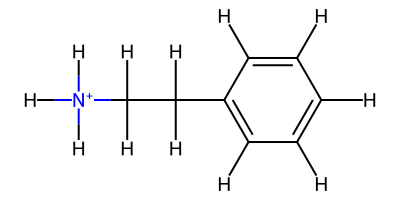
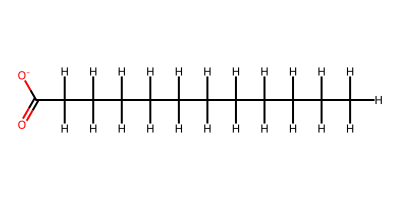
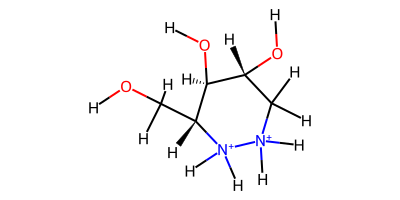
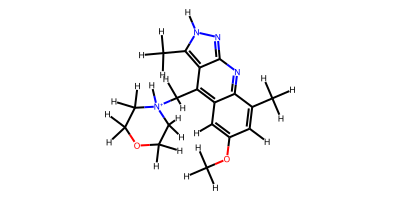
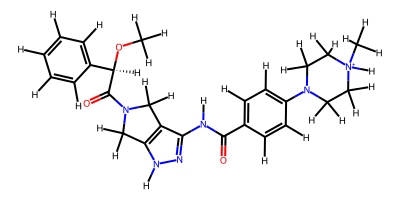
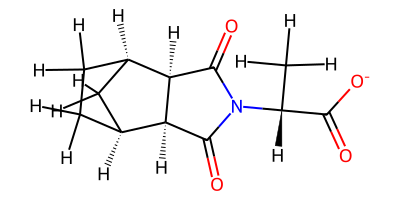
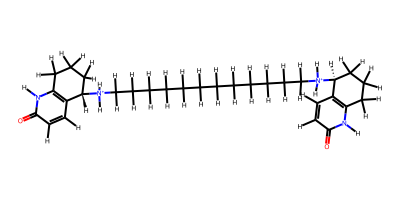
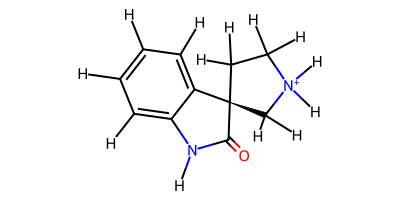
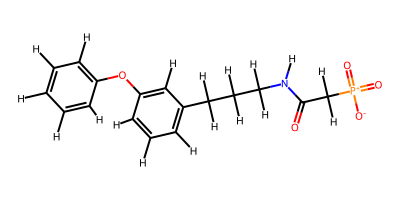
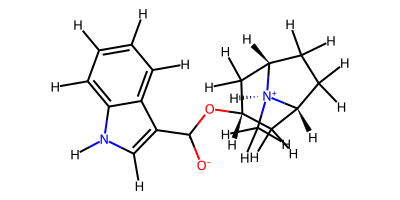
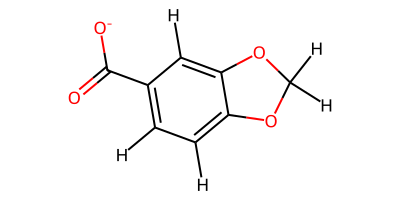
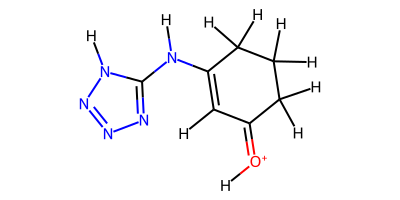
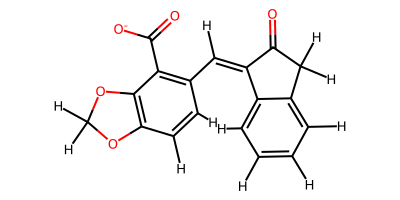
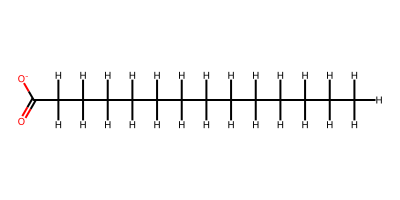
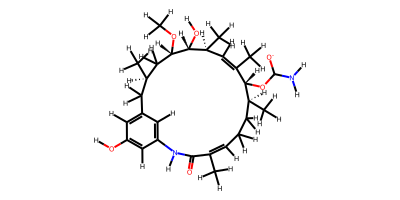
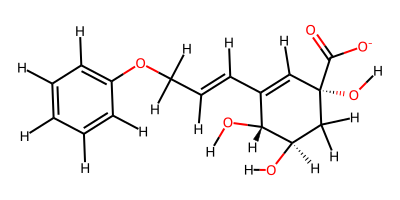
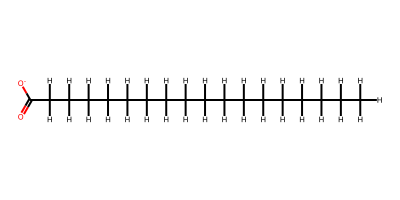
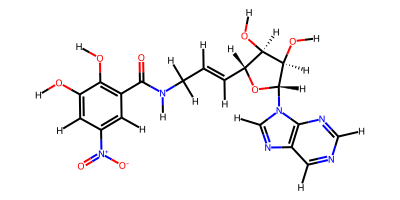
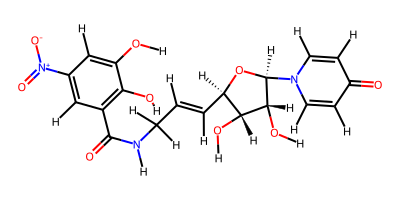

In [80]:
PDBbind_285 = pd.read_csv('PDBbind_285.csv', index_col=False)
PDBbind_285_filtered = PDBbind_285[PDBbind_285["Has_Charged_Atoms"] == True]
allowed_atoms = {"C", "N", "H", "O", "P"}
PDBbind_285_filtered_CHNOP = PDBbind_285_filtered[PDBbind_285_filtered["Atom_Types"].apply(lambda x: set(x.split(",")) <= allowed_atoms)]
PDBbind_285_filtered_CHNOP.style.set_properties(subset=['2D_Image'], **{'text-align': 'center'}, )

In [81]:
# test_path_list = glob.glob('demo/*/*.mol2')[4]
name = '4abg'
test_path_list = f'PDBbind_demo/{name}/{name}_ligand.mol2'
test_chem = mol2_to_chem(test_path_list)

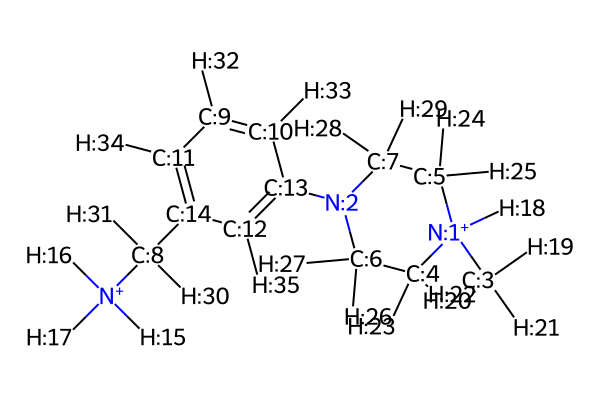

In [82]:
draw_mol_with_atom_index(test_chem)

### psiresp

In [83]:
constraint_dict = {'test_chem':
                  {'symmetric_list': [],
                   'charge_atom_dict': {},
                   'charge_of_monomer': 2.0000,
                  }
                  }

In [84]:
param_mol_name = 'test_chem'
psiresp_dict = {}
RESP_mol= psiresp.Molecule.from_rdkit(test_chem,
                                      optimize_geometry = True, charge=2, 
                                      conformer_generation_options = dict(n_conformer_pool=10000, 
                                      n_max_conformers=5, energy_window = 120, keep_original_conformer=False))
psiresp_dict[param_mol_name] = RESP_mol
constraints = psiresp.ChargeConstraintOptions(symmetric_atoms_are_equivalent = True) # Если True, то сваливается в ошибку как не крути органичения :с 
constraints = pt.add_constraint(RESP_mol, 
                                constraint_dict[param_mol_name]['symmetric_list'] , 
                                constraint_dict[param_mol_name]['charge_atom_dict'], 
                                constraint_dict[param_mol_name]['charge_of_monomer'],
                                constraints = constraints)

/home/n_kristovsky/.conda/envs/topmol2/lib/python3.8/site-packages/psiresp/charge.py:282: FutureWarning: `symmetric_atoms_are_equivalent` will be set to False by default for now, as it is a new feature. It will be set to True by default in the future
  warnings.warn(


In [85]:
constraints

ChargeConstraintOptions(charge_sum_constraints=[ChargeSumConstraint(atoms=set(), charge=2.0)], charge_equivalence_constraints=[], split_conformers=False, constrain_methyl_hydrogens_between_conformers=False, symmetric_methyls=True, symmetric_methylenes=True, symmetric_atoms_are_equivalent=True)

In [86]:
psiresp_dict

{'test_chem': Molecule(name=C12H21N3, charge=2) with 1 conformers}

In [88]:
job = pt.resp_calculation(psiresp_dict, constraints, n_processes = 4)

Выполнение run_optimization.sh.. Новое имя директории: test_chem


generate-conformers: 100%|██████████| 1/1 [00:00<00:00, 6278.90it/s]

Время выполнения: 00:00:00


Выполнение run_optimization.sh...Колличество конформеров: 1
Выполнение run_optimization.sh.  
run_optimization.sh выполнен успешно!
Время выполнения: 00:01:03


generating-orientations: 100%|██████████| 1/1 [00:00<00:00, 46.17it/s]

Выполнение run_optimization.sh.. 

Выполнение run_optimization.sh.  
run_single_point.sh выполнен успешно!
Время выполнения: 00:00:36


compute-esp: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]


Выполнение run_optimization.sh...

forrtl: error (78): process killed (SIGTERM)
Image              PC                Routine            Line        Source             
libgdma.so         00007F079093F10F  for__signal_handl     Unknown  Unknown
libpthread-2.27.s  00007F07EC499980  Unknown               Unknown  Unknown
python3.8          0000563168E18F6C  Unknown               Unknown  Unknown
python3.8          0000563168E006DF  _PyEval_EvalFrame     Unknown  Unknown
python3.8          0000563168E0B8A6  _PyFunction_Vecto     Unknown  Unknown
python3.8          0000563168DFBA55  _PyEval_EvalFrame     Unknown  Unknown
python3.8          0000563168E03958  _PyObject_FastCal     Unknown  Unknown
python3.8          0000563168E154AF  Unknown               Unknown  Unknown
python3.8          0000563168E04324  _PyObject_MakeTpC     Unknown  Unknown
python3.8          0000563168DFFDD7  _PyEval_EvalFrame     Unknown  Unknown
python3.8          0000563168E0B8A6  _PyFunction_Vecto     Unknown  Unknown
python3.8          0000563168DF

Выполнение run_optimization.sh...

In [89]:
round_charges = job.molecules[0].charges.round(4)
print(sum(round_charges), round_charges, sep = '\n')

2.0001
[-0.8098  0.2877 -0.1542 -0.0606 -0.1934 -0.2305  0.1135  0.2039  0.5196
 -0.1144 -0.122  -0.1008 -0.2414  0.2661  0.1023  0.2629  0.2741  0.6823
 -0.2602  0.2154  0.2154  0.2154  0.0098  0.0098  0.086   0.086  -0.0335
 -0.0335 -0.0039 -0.0039 -0.1134 -0.1134  0.2259  0.2713  0.2288  0.3128]
Выполнение run_optimization.sh.. 

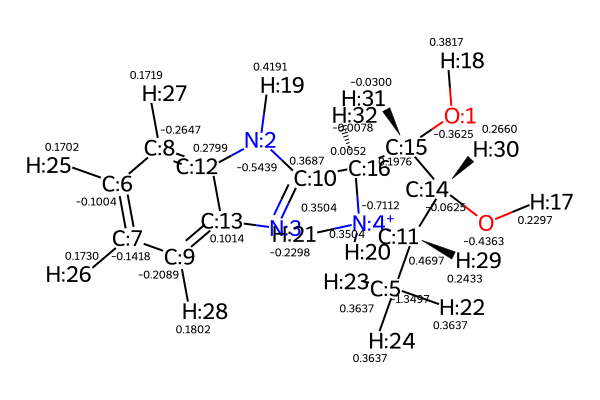

In [30]:
pt.draw_mol_with_atom_index(test_chem, charge_list=round_charges)